# <center><font color=gray>Prédiction de la catégorie d'un produit à partir de données textuelles</font>
***

In [1]:
import pandas as pd
df = pd.read_csv('train.csv',header=0,sep=';', encoding = 'unicode_escape')
#utf-8 permet de garder les accents, unicode_escape les remplace.
df.head()

,category_id,category,title,description
0,0,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque Samsung ACE S5830 Cassette audio transp...,Coque Samsung ACE S5830 Cassette audio transp...
1,0,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque rigide Violette pour NOKIA LUMIA 625 mot...,Coque rigide Violette pour NOKIA LUMIA 625 mot...
2,0,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque rigide Rose bonbon pour HUAWEI ASCEND P2...,Coque rigide Rose bonbon pour HUAWEI ASCEND P2...
3,0,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque souple Grise pour SONY XPERIA Z1 motif D...,Coque souple Grise pour SONY XPERIA Z1 motif D...
4,0,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,"Coque HTC One S 4,3'' â Dessin TÃªte de Gira...","Coque HTC One S 4,3'' â Dessin TÃªte de Gira..."


## Une méthode pour utiliser TF IDF est de concaténer les variables textuelles 
#### Les deux variables *`title`* et  *`description`* sont regroupées dans la variable *`txt`*

In [2]:
df["txt"] = df["title"].map(str) + df["description"]
del df['description']
del df['title']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
category_id    20000 non-null int64
category       20000 non-null object
txt            20000 non-null object
dtypes: int64(1), object(2)
memory usage: 468.8+ KB


In [3]:
col = ['category', 'txt']
df = df[col]
df.columns

Index(['category', 'txt'], dtype='object')

In [4]:
df.columns = ['category', 'txt']

#### Pre-processing
#### Avec un dictionnaire français, pour plus d'optimisation, '`Tokenization`', '`Stemming`' et '`Lemmatization`', peuvent être utilisés.

In [5]:
df['category_id'] = df['category'].factorize()[0]
from io import StringIO
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [6]:
df.head()

,category,txt,category_id
0,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque Samsung ACE S5830 Cassette audio transp...,0
1,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque rigide Violette pour NOKIA LUMIA 625 mot...,0
2,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque rigide Rose bonbon pour HUAWEI ASCEND P2...,0
3,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque souple Grise pour SONY XPERIA Z1 motif D...,0
4,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,"Coque HTC One S 4,3'' â Dessin TÃªte de Gira...",0


#### Vérifier s'il y a des données non équilibrées :

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').txt.count().plot.bar(ylim=0, color=('tan'))
plt.show()

<Figure size 800x600 with 1 Axes>

#### 1000 observations pour chaque catégorie

### TfidfVectorizer
#### Pour chaque terme de l'échantillon, calculer la mesure TF-IDF (Term Frequency, Inverse Document Frequency) 
#### TF = (Nombre de fois que le terme `T` apparaît dans la ligne) / (nombre de termes dans cette ligne)
#### IDF = L'intuition de l'Inverse Document Frequency (IDF) est qu'un mot ne nous est pas d'une grande utilité s'il apparaît dans tous les documents. → `log(N/n)`, où, `N` est le nombre total de lignes et `n` est le nombre de lignes dans lesquelles le mot est présent 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df.txt).toarray()
labels = df.category_id

features.shape

(20000, 15390)

#### Chacune des 20000 entrées textes est représentée par 15390 features, représentant le score TF-IDF pour les unigrammes et bigrammes.

#### N-grams : Les termes corrélés :
#### N-grams sont la combinaison de plusieurs mots utilisés ensemble. Les N-grams avec N=1 sont appelés unigrammes. De même, les bigrammes (N=2), les trigrammes (N=3) et ainsi de suite peuvent également être utilisés.

In [9]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("* Most correlated unigrams:\n.{}".format('\n. '.join(unigrams[-N:])))
  print("* Most correlated bigrams:\n.{}".format('\n. '.join(bigrams[-N:])))

# 'AUTO - MOTO (NEW) | PIECES | KIT GROS FREIN':
* Most correlated unigrams:
.freins
. sport
* Most correlated bigrams:
.gros freins
. kit gros
# 'BIJOUX -  LUNETTES - MONTRES | BIJOUX | BOUCLE D OREILLE':
* Most correlated unigrams:
.boucles
. oreilles
* Most correlated bigrams:
.oreilles en
. boucles oreilles
# 'BIJOUX -  LUNETTES - MONTRES | BIJOUX | BRACELET - GOURMETTE':
* Most correlated unigrams:
.bracelets
. bracelet
* Most correlated bigrams:
.bracelet en
. bijoux bracelet
# 'BIJOUX -  LUNETTES - MONTRES | BIJOUX | SAUTOIR ET COLLIER':
* Most correlated unigrams:
.pendentif
. collier
* Most correlated bigrams:
.chaã ne
. collier en
# 'BIJOUX -  LUNETTES - MONTRES | MONTRES | MONTRE BRACELET':
* Most correlated unigrams:
.authentique
. montre
* Most correlated bigrams:
.acheter authentique
. montre femme
# 'CULTURE - JEUX | MUSIQUE | CD':
* Most correlated unigrams:
.by
. cd
* Most correlated bigrams:
.ceci est
. track listing
# 'DECO - LINGE - LUMINAIRE | DECORATION MURALE - T

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['txt'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

#### Tests préliminaires

In [11]:
print(clf.predict(count_vect.transform(["Coque Samsung ACE S5830 Cassette audio transp..."])))
print(clf.predict(count_vect.transform(["Boucles Argent"])))

['TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQUE - BUMPER - FACADE TELEPHONE']
['BIJOUX -  LUNETTES - MONTRES | BIJOUX | BOUCLE D OREILLE']


### Choix de modèle Machine Learning à appliquer : 
#### Les modèles sont cross validés 5 fois pour plus de fiabilité.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Asch\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asch\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Asch\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asch\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Asch\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver 

### Visualisation de la précision de chaque modèle

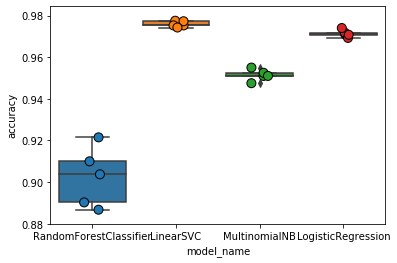

In [13]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=9, jitter=True, edgecolor="black", linewidth=1)
plt.show()

#### Précision de chaque modèle

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.97590
LogisticRegression        0.97135
MultinomialNB             0.95140
RandomForestClassifier    0.90245
Name: accuracy, dtype: float64

#### *SVC* : 97.5%
#### Prédiction sur l'échantillon de test

In [15]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Matrcie de confusion

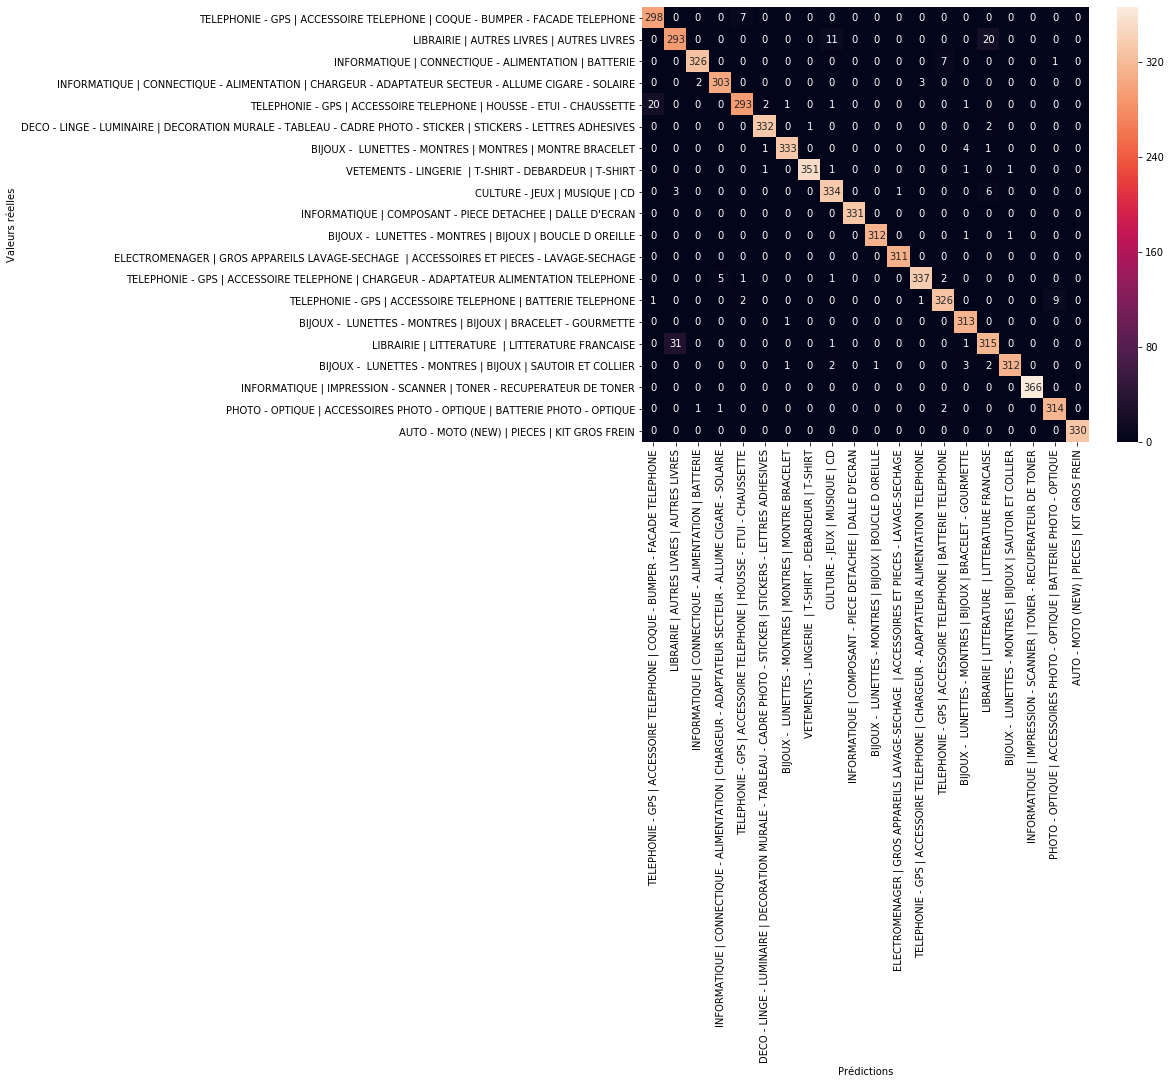

In [16]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, 
            yticklabels=category_id_df.category.values)
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

#### A ce niveau il faut se pencher sur les erreurs du modèle pour savoir ce que cause que des observations sont mal classées comme le montre la matrice de confusion

In [17]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'txt']])
      print('')

'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUSSE - ETUI - CHAUSSETTE' predicted as 'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQUE - BUMPER - FACADE TELEPHONE' : 20 examples.


,category,txt
4144,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque souple Bleue pour LG G2 motif Ultraviole...
4367,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque souple Violette pour NOKIA LUMIA 525 mot...
4904,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque rigide Jaune pour ALCATEL OT / 6010D mot...
4866,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque rigide Bleu lagon pour LG G2 motif Cordo...
4293,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque rigide Violette pour SONY XPERIA Z2 moti...
4653,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Hello Kitty - ChaussetteHello Kitty - Chausset...
4206,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque souple Grise pour SONY XPERIA Z1 motif D...
4326,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque rigide Noire pour ALCATEL ONE TOUCH IDOL...
4340,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Housse de silicone lisse noire pour HTC Desire...
4857,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUS...,Coque souple Rouge pour NOKIA LUMIA 925 motif ...



'LIBRAIRIE | LITTERATURE  | LITTERATURE FRANCAISE' predicted as 'LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES' : 31 examples.


,category,txt
15410,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,Saint-Jules gros orteilDe Henri Rouille D'Orfe...
15334,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,ThÃ©rÃ¨se RaquinDe Emile Zola aux Ã©ditions PO...
15618,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,Discours d'investiture de la prÃ©sidente des E...
15775,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,FlÃ¢ner en FranceDe Jacques LacarriÃ¨re aux Ã©...
15518,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,Hira MandiDe Claudine Le Tourneur D'Ison aux Ã...
15619,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,Le mystÃ¨re du trÃ©sor de Sistrius en Auvergne...
15991,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,Souvenirs des jours heureuxDe Julien Green aux...
15554,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,"Geronimo, dans ma poitrine un nuage s'endortDe..."
15382,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,Clair-obscurDe Collectif aux Ã©ditions MAELSTROM
15441,LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE,"AmÃ©ricain, AmÃ©ricainDe Hubert Prolongeau aux..."



'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQUE - BUMPER - FACADE TELEPHONE' predicted as 'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUSSE - ETUI - CHAUSSETTE' : 7 examples.


,category,txt
693,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Briller Hard Housse Coque Etui Case LG G3 Colo...
413,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque rigide Violette pour HUAWEI ASCEND P2 mo...
88,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Plastique transparent + fluorescentes effet ca...
65,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Ãtui Housse Coque Portefeuille Cuir iPhone 6 ...
146,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Coque Plexiglass Moxie contour et griffes coul...
598,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Housse Ã©tui coque Ã rabat + clip ceinture po...
157,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...,Housse-Etui avec coque de protection Noir Surp...



'LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES' predicted as 'CULTURE - JEUX | MUSIQUE | CD' : 11 examples.


,category,txt
1751,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Fortune's Fool - Fred GoodmanFortune's Fool - ...
1467,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,"Stolen - Christopher, LucyStolen - Christopher..."
1752,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Toni Morrison - Lucille P. FultzToni Morrison ...
1416,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Swallows and Amazons - Arthur RansomeSwallows ...
1499,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Forming the Critical Mind ÃÃÃ´ Dryden to Col...
1180,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Once Upon a Sign - Kimberly Taylor-DiLevaOnce ...
1818,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,"Anglo-Saxon England: Volume 36 - Godden, Malco..."
1290,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Nuns And Soldiers - Iris MurdochNuns And Soldi...
1783,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Blackwater - Conn IgguldenBlackwater - Conn Ig...
1916,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Veniss Underground - Jeff VanderMeerVeniss Und...



'INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BATTERIE' predicted as 'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATTERIE TELEPHONE' : 7 examples.


,category,txt
2181,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,MicroBattery - Batterie de portable - 1 x Lith...
2817,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,Batterie type PA5026U-1BRS pour portable Batte...
2724,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,Batterie pour TOSHIBA Satellite L755-S5239Batt...
2641,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,Acer - Batterie de portable - 1 x Lithium Ion ...
2952,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,Batterie pour portable SONY VAIO VGN-NS25GPBat...
2374,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,Batterie d'origine constructeur pour type/rÃ©f...
2575,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BA...,Batterie type 312-0575 pour ordinateur portabl...



'LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES' predicted as 'LIBRAIRIE | LITTERATURE  | LITTERATURE FRANCAISE' : 20 examples.


,category,txt
1884,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,STONEWIELDER ...
1150,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Saint-malo 2000-2001De Dominique Auzias - Jean...
1143,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Les loups du paradisDe Sophie ChÃ©rer aux Ã©di...
1727,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,"BELLE-ILE, HOUAT, HOEDICDe Jean-Louis GuÃ©ry a..."
1724,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,EL COMTE ARNAUEL COMTE ARNAU - XXX
1710,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Le petit ecrivainDe Gilles Tibo aux Ã©ditions ...
1523,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,"A MODEL FOR LIVINGA MODEL FOR LIVING - SHORT, ..."
1992,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Memoires. t 38-2.(1987) les maires du vaDe Par...
1946,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,GUIDE PETIT FUTE CARNETS DE VOYAGE AMSTERDA...
1001,LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES,Precis de teratologie edition 1893De Guinard L...



'CULTURE - JEUX | MUSIQUE | CD' predicted as 'LIBRAIRIE | LITTERATURE  | LITTERATURE FRANCAISE' : 6 examples.


,category,txt
8112,CULTURE - JEUX | MUSIQUE | CD,Tant de temps by JacnoTant de temps by Jacno -...
8714,CULTURE - JEUX | MUSIQUE | CD,"LISZT / PIANO SONATA IN B MINOR, ANNÃES DE PÃ..."
8241,CULTURE - JEUX | MUSIQUE | CD,Le Bossu De Notre-Dame (B.O.F.) (Version U.S.)...
8965,CULTURE - JEUX | MUSIQUE | CD,"Pierre & le Loup Lambert Wilson, rÃ©c., Capito..."
8426,CULTURE - JEUX | MUSIQUE | CD,Bob Azzam et son orchestre : MustaphaBob Azzam...
8578,CULTURE - JEUX | MUSIQUE | CD,LES CHOEURS DE L ARMEE ROUGE - LIVE 2013 L'Alb...



'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATTERIE TELEPHONE' predicted as 'PHOTO - OPTIQUE | ACCESSOIRES PHOTO - OPTIQUE | BATTERIE PHOTO - OPTIQUE' : 9 examples.


,category,txt
13041,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Batterie pour PHILIPS TD 9603Batterie pour PHI...
13546,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,"Batterie APN type OLYMPUS LI-70B 3,7V L7Batter..."
13440,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Batterie pour Kenwood TK-380 2100mAh NiMHBatte...
13061,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Batterie pour DOGTRA 282NCPBatterie pour DOGTR...
13627,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Batterie pour SAMSUNG GALAXY S III T999Batteri...
13176,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Batterie pour Panasonic KX-TG2226SVBatterie po...
13105,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Batterie pour PANASONIC GD87Batterie pour PANA...
13480,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,"Batterie APN type MIN NP-900 3,7V L6/7Batterie..."
13695,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | BATT...,Sharp XN-1BT90 BatterieSharp XN-1BT90 Batterie...


#### Les accents en Français peuvent causer un problème, mais dand ce cas, j'ai remarqué qu'enlever les accents, la ponctuation, normaliser en miniscule (à travers les méthodes ci dessous) donne des résultats moins bons sur la matrice de confusion, la précision et le nombre de features TF-IDF baissent égelement, pour cela j'ai décidé de conserver le texte tel qu'il est.  
#### str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#### str.replace('[^\w\s]','')
#### str.lower()

In [18]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

#### N-grams

In [19]:
from sklearn.feature_selection import chi2

N = 2

for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("* Top unigrams:\n.{}".format('\n. '.join(unigrams)))
  print("* Top bigrams:\n.{}".format('\n. '.join(bigrams)))

# 'AUTO - MOTO (NEW) | PIECES | KIT GROS FREIN':
* Top unigrams:
.freins
. pistons
* Top bigrams:
.kit gros
. gros freins
# 'BIJOUX -  LUNETTES - MONTRES | BIJOUX | BOUCLE D OREILLE':
* Top unigrams:
.boucles
. oreilles
* Top bigrams:
.boucles oreilles
. boucles crã
# 'BIJOUX -  LUNETTES - MONTRES | BIJOUX | BRACELET - GOURMETTE':
* Top unigrams:
.bracelet
. bracelets
* Top bigrams:
.bracelet crã
. bracelet femme
# 'BIJOUX -  LUNETTES - MONTRES | BIJOUX | SAUTOIR ET COLLIER':
* Top unigrams:
.collier
. pendentif
* Top bigrams:
.collier crã
. chaã ne
# 'BIJOUX -  LUNETTES - MONTRES | MONTRES | MONTRE BRACELET':
* Top unigrams:
.montre
. montres
* Top bigrams:
.montre femme
. montre homme
# 'CULTURE - JEUX | MUSIQUE | CD':
* Top unigrams:
.by
. cd
* Top bigrams:
.track listing
. cdâ voir
# 'DECO - LINGE - LUMINAIRE | DECORATION MURALE - TABLEAU - CADRE PHOTO - STICKER | STICKERS - LETTRES ADHESIVES':
* Top unigrams:
.sticker
. stickers
* Top bigrams:
.100 cm
. violet antique
# 'ELECTROME

#### Test des premières observations du fichier test.csv

In [20]:
texts = ["HTC One X / X+ coque dure case noir - Naives Kätzchenmuster",
         "Xoxo XO1084 femmes Montre",
         "L'Europe et la Révolution française. I, Les moeurs",
         "Kit Gros Freins K-Sport 8 Pistons RENAULT NEW  …",
         "Chargeur + Chargeur allume cigare + Cable USB +…"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("* Catégorie prédite : '{}'".format(id_to_category[predicted]))
  print("")

"HTC One X / X+ coque dure case noir - Naives Kätzchenmuster"
* Catégorie prédite : 'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQUE - BUMPER - FACADE TELEPHONE'

"Xoxo XO1084 femmes Montre"
* Catégorie prédite : 'BIJOUX -  LUNETTES - MONTRES | MONTRES | MONTRE BRACELET'

"L'Europe et la Révolution française. I, Les moeurs"
* Catégorie prédite : 'LIBRAIRIE | LITTERATURE  | LITTERATURE FRANCAISE'

"Kit Gros Freins K-Sport 8 Pistons RENAULT NEW  …"
* Catégorie prédite : 'AUTO - MOTO (NEW) | PIECES | KIT GROS FREIN'

"Chargeur + Chargeur allume cigare + Cable USB +…"
* Catégorie prédite : 'TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | CHARGEUR - ADAPTATEUR ALIMENTATION TELEPHONE'



#### Local and overall metrics

In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['category'].unique()))

                                                                                                               precision    recall  f1-score   support

                                  TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQUE - BUMPER - FACADE TELEPHONE       0.93      0.98      0.96       305
                                                                    LIBRAIRIE | AUTRES LIVRES | AUTRES LIVRES       0.90      0.90      0.90       324
                                                         INFORMATIQUE | CONNECTIQUE - ALIMENTATION | BATTERIE       0.99      0.98      0.98       334
          INFORMATIQUE | CONNECTIQUE - ALIMENTATION | CHARGEUR - ADAPTATEUR SECTEUR - ALLUME CIGARE - SOLAIRE       0.98      0.98      0.98       308
                                         TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | HOUSSE - ETUI - CHAUSSETTE       0.97      0.92      0.94       318
DECO - LINGE - LUMINAIRE | DECORATION MURALE - TABLEAU - CADRE PHOTO - STICKER | STICKERS - L

#### Validation
#### !! Changer le séparateur en (',') dans le fichier CSV avant  de le charger

In [22]:
dt = pd.read_csv('test.csv',header=0,sep=';', encoding = 'unicode_escape')
dt.head()

,id,title,description
0,0,HTC One X / X+ coque dure case noir - Naives K...,HTC One X / X+ coque dure case noir - Naives K...
1,1,Xoxo XO1084 femmes Montre,Xoxo XO1084 femmes Montre - Acheter Authentiqu...
2,2,"L'Europe et la Révolution française. I, Les mo...",Albert Sorel
3,3,Kit Gros Freins K-Sport 8 Pistons RENAULT NEW,Kit Gros Freins K-Sport 8 Pistons RENAULT NEW ...
4,4,Chargeur + Chargeur allume cigare + Cable USB +,Chargeur + Chargeur allume cigare + Cable USB ...


In [23]:
dt["txt"] = dt["title"].map(str) + dt["description"]
del dt['title']
del dt['description']
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
id     20000 non-null int64
txt    20000 non-null object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [24]:
valid = dt['txt']
id = dt['id']

#### Prédiction de la catégorie :

In [33]:
""""list1=[]
list2=[]
text_features = tfidf.transform(valid)
predictions = model.predict(text_features)
for text, predicted in zip(valid, predictions):
  list1.append(text)
  list2.append(id_to_category[predicted])""""

'list1=[]\nlist2=[]\ntext_features = tfidf.transform(valid)\npredictions = model.predict(text_features)\nfor text, predicted in zip(valid, predictions):\n  list1.append(text)\n  list2.append(id_to_category[predicted])'

In [30]:
list1=[]
text_features = tfidf.transform(valid)
predictions = model.predict(text_features)
for text, predicted in zip(valid, predictions):
  list1.append([text,id_to_category[predicted]])

In [31]:
pd.DataFrame(list1).to_csv

,0,1
0,HTC One X / X+ coque dure case noir - Naives K...,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...
1,Xoxo XO1084 femmes MontreXoxo XO1084 femmes Mo...,BIJOUX - LUNETTES - MONTRES | MONTRES | MONTR...
2,"L'Europe et la Révolution française. I, Les mo...",LIBRAIRIE | LITTERATURE | LITTERATURE FRANCAISE
3,Kit Gros Freins K-Sport 8 Pistons RENAULT NEW ...,AUTO - MOTO (NEW) | PIECES | KIT GROS FREIN
4,Chargeur + Chargeur allume cigare + Cable USB ...,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | CHAR...
5,Seiko SGEG8 Hommes MontreSeiko SGEG8 Hommes Mo...,BIJOUX - LUNETTES - MONTRES | MONTRES | MONTR...
6,Coque iPhone 5 & 5S Green PlantsCoque iPhone 5...,TELEPHONIE - GPS | ACCESSOIRE TELEPHONE | COQU...
7,BRACELET FANTAISIE ARGENT BRACELET FANTAISIE A...,BIJOUX - LUNETTES - MONTRES | BIJOUX | BRACEL...
8,Batterie pour PENTAX 645Batterie pour PENTAX 6...,PHOTO - OPTIQUE | ACCESSOIRES PHOTO - OPTIQUE ...
9,Alimentation d'ordinateur hp compaq presario r...,INFORMATIQUE | CONNECTIQUE - ALIMENTATION | CH...


##### Les catégories prédites gardent le même ordre que sur le fichier d'entrée

In [26]:
import xlsxwriter

xbook = xlsxwriter.Workbook('Predictions.xlsx')
xsheet = xbook.add_worksheet('Test')

for idx, pred in enumerate(list2):
    xsheet.write(idx,0,list2[idx])

xbook.close()